<a href="https://colab.research.google.com/github/leticiafcarvalho/DeteccaoFriends/blob/main/DeteccaoFriends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Passo 1: Instalar as bibliotecas necessárias
!pip install tensorflow keras opencv-python-headless matplotlib mtcnn

In [3]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=8d26c7d916d4bc519bb12f34935e0aff1ec60ee42feaf0dfde8db073bdbb0b05
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [4]:
# Importações necessárias
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array
from deepface import DeepFace
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

24-11-29 18:40:09 - Directory /root/.deepface has been created
24-11-29 18:40:09 - Directory /root/.deepface/weights has been created


In [5]:
# Carregar o modelo ResNet50
model = ResNet50(weights='imagenet')

In [6]:
# Lista com os nomes dos personagens na ordem esperada
character_names = ["Chandler", "Rachel", "Ross", "Monica", "Joey", "Phoebe"]

# Base de dados com imagens de referência (caminhos das imagens dos personagens)
reference_images = {
    "Monica": "./Monica.jpg",
    "Ross": "./Ross.jpg",
    "Rachel": "./Rachel.jpg",
    "Chandler": "./Chandler.jpg",
    "Joey": "./Joey.jpg",
    "Phoebe": "./Phoebe.jpg"
}

In [7]:
# Função para calcular embeddings das imagens de referência
def create_reference_embeddings(reference_images):
    embeddings = {}
    for name, img_path in reference_images.items():
        embedding = DeepFace.represent(img_path=img_path, model_name='Facenet', enforce_detection=False)
        embeddings[name] = embedding[0]["embedding"]
    return embeddings

# Criar a base de dados de embeddings
reference_embeddings = create_reference_embeddings(reference_images)

24-11-29 18:40:55 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 260MB/s]


In [12]:
# Função para calcular o embedding de uma face detectada
def get_face_embedding(face_img):
    face_resized = cv2.resize(face_img, (224, 224))
    face_array = img_to_array(face_resized)
    face_preprocessed = np.expand_dims(face_array, axis=0)
    # Normalizar como o modelo ResNet50 espera
    face_preprocessed = face_preprocessed / 255.0
    # Utilizar DeepFace para calcular o embedding facial
    embedding = DeepFace.represent(img_path=face_img, model_name='Facenet', enforce_detection=False)
    return embedding[0]["embedding"]


In [8]:
# Detector de faces usando MTCNN
detector = MTCNN()

In [13]:
# Função para detectar faces e adicionar os nomes dos personagens
def detect_faces_and_classify_with_names(image_path):
    """Detecta faces em uma imagem, calcula embeddings e classifica com base nos embeddings dos personagens."""
    # Ler a imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detector de faces
    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)
    face_classifications = []

    for i, face in enumerate(faces):
        x, y, width, height = face['box']
        face_img = image_rgb[y:y+height, x:x+width]

        # Calcular o embedding da face detectada
        face_embedding = get_face_embedding(face_img)

        # Comparar com os embeddings dos personagens
        best_match_name = None
        best_match_distance = float('inf')  # Inicializa a distância com valor muito grande
        for name, reference_embedding in reference_embeddings.items():
            # Calcular a distância euclidiana entre os embeddings
            distance = np.linalg.norm(np.array(face_embedding) - np.array(reference_embedding))
            if distance < best_match_distance:
                best_match_distance = distance
                best_match_name = name

        # Desenhar a face e o rótulo na imagem original
        label = f"{best_match_name} ({best_match_distance:.2f})"
        face_classifications.append(label)
        cv2.rectangle(image_rgb, (x, y), (x+width, y+height), (0, 255, 0), 2)
        cv2.putText(image_rgb, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    return image_rgb, face_classifications


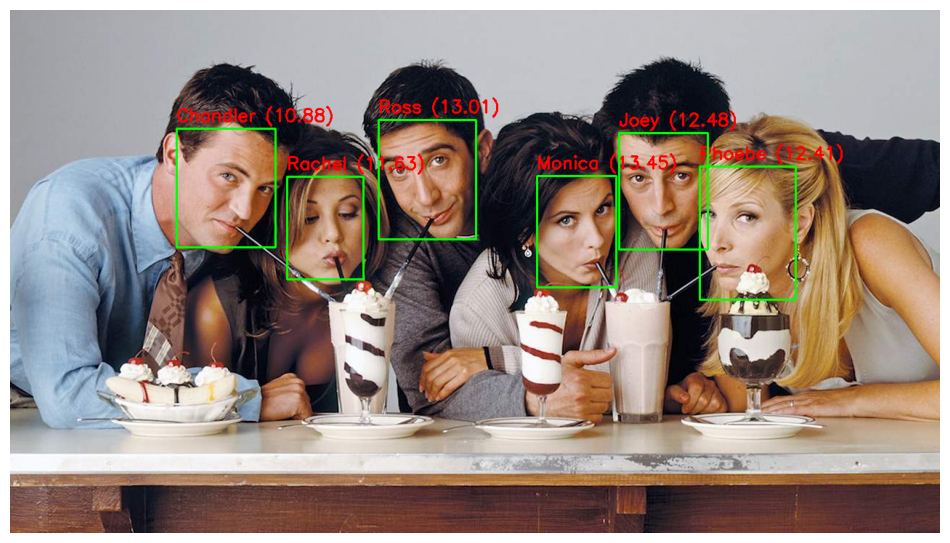

Classificações detectadas:
Face 1: Monica (13.45)
Face 2: Chandler (10.88)
Face 3: Phoebe (12.41)
Face 4: Ross (13.01)
Face 5: Joey (12.48)
Face 6: Rachel (11.63)


In [14]:
# Caminho para a imagem que você quer analisar
image_path = './friends.jpg'  # Substitua pelo caminho correto da sua imagem

# Chamar a função para detectar e classificar as faces
classified_image, classifications = detect_faces_and_classify_with_names(image_path)

# Exibir a imagem com as detecções e classificações
plt.figure(figsize=(12, 12))
plt.imshow(classified_image)
plt.axis("off")
plt.show()

# Exibir as classificações no console
print("Classificações detectadas:")
for idx, classification in enumerate(classifications):
    print(f"Face {idx + 1}: {classification}")

identificou errado, pode me ajudar a arrumar